# Overview [03/02/2023]

*version 2*

Unified Code:
* Detele duplicates
* Delete users with less than 10 interactions

# Unified code

In [1]:
#====================== Import de librerias =====================#
import os
from pathlib import Path
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import datetime
import plotly.express as px
import plotly.graph_objects as go
import wget
import logging
import plotly.express as px
import plotly.graph_objects as go

logfile = "project.log"
old_path = os.getcwd()

if not os.getcwd().split(os.sep)[-1] == "Implementation":
    os.chdir("..")
execution_path = os.getcwd()

In [6]:
#============ Definicion de valores de configuracion ============#

# logging.basicConfig(
#     filename=logfile, 
#     level=logging.DEBUG, 
#     datefmt='%Y-%m-%d %H:%M:%S',
#     format='%(asctime)s  %(message)s')

# with open(execution_path/Path("1_Datos/urls.json"), "r") as f:
#     data_info = json.loads(f.readline())
# Url de dataset que queremos descargar
# urls= [data_info["url"]]
urls = ["https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Musical_Instruments.csv"]
        

# Minimo de reviews por usuario
min_reviews, min_usuarios = [8,8]

# Columns names
col_names = {"col_id_product": "asin",
             "col_id_reviewer": "reviewerID",
             "col_rating": "overall",
             "col_unix_time": "unixReviewTime",
             "col_timestamp": "timestamp",
             "col_year": "year"}

csv_filename = execution_path/Path("3_DataPreparation/interactions_minR{}_minU{}.csv".format(min_reviews,min_usuarios))

In [4]:
#============ Definicion de funciones de extraccion y tratamiento ============#

def get_dataset_basic_info(df, nombre):
  '''
  Funcion que retorna infomracion de # de clientes, productos y reviews en dataset elegido
  '''
  aux=len(nombre)
  numero_clientes=len(df[col_names["col_id_reviewer"]].unique())
  numero_productos=len(df[col_names["col_id_product"]].unique())

  lines = [
    "#"*aux,
    nombre.center(aux),
    "#"*aux,
    "Numero total de clientes: {}".format(numero_clientes),
    "Numero total de products: {}".format(numero_productos),
    "Numero total de reviews: {}".format(df.shape[0])
  ]
  to_print = ""
  for line in lines:
    to_print+=line+"\n"
    logging.debug(line)
  return(to_print)

def clear_content_logger(logfile):
    with open(logfile, 'w'):
        pass

def load_data_raw():
  '''
  Funcion que descarga los datasets de las url elegidas. 
  '''
  filename = wget.download(urls[0])
  df = pd.read_csv(filename, delimiter=",", names=[*col_names.values()][:4])
  print(get_dataset_basic_info(df,"Download the infromation from RAW dataset"))
  os.remove(filename)
  
  return df

def treat_dataset_src(df, min_reviews,info=False):

    '''
    Funcion que trata el dataset original
    Realiza conversiones de tipo
    Filtra duplicados (usuarios que han puesto mas de una review sobre un producto el mismo día)
    Filtra productos comprados por al menos 3 usuarios
    Filtra solo usuarios con mas de X reviews
    '''
    logging.info("Min users per product: {}".format(min_usuarios))
    logging.info("Min reviews per user: {}".format(min_reviews))
    
    # Conversion de tipo
    df[col_names["col_rating"]] = pd.to_numeric(df[col_names["col_rating"]].replace(',','', regex=True))
    df[col_names["col_timestamp"]]=df[col_names["col_unix_time"]].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    df[col_names["col_year"]]= pd.to_datetime(df[col_names["col_timestamp"]]).dt.year

    # Duplicados
    df_duplicates = df[[col_names["col_id_reviewer"],col_names["col_id_product"], col_names["col_unix_time"]]].sort_values(by=[col_names["col_unix_time"]], ascending=False)
    df = df.drop(df_duplicates[df_duplicates[[col_names["col_id_reviewer"],col_names["col_id_product"]]].duplicated()][col_names["col_id_reviewer"]].index.values.tolist())
   
    if (info==True):
      get_dataset_basic_info(df,"Informacion tras eliminar duplicados")

    productos_a_eliminar=[1]
    clientes_a_eliminar=[1]
    iteracion = 1
    while (len(productos_a_eliminar)!=0)and(len(clientes_a_eliminar)!=0):

      # Minimo de usuarios que han comprado el producto productos 
      aux=df.groupby([col_names["col_id_product"]])[col_names["col_id_reviewer"]].count().reset_index()
      aux2=aux[aux[col_names["col_id_reviewer"]]<min_usuarios].reset_index() # usuarios a eliminar
      aux=aux[aux[col_names["col_id_reviewer"]]>=min_usuarios].reset_index() # usuarios a conservar
      productos=aux[col_names["col_id_product"]]
      df=df[df[col_names["col_id_product"]].isin(productos)]

      productos_a_eliminar=aux2[col_names["col_id_product"]]


      if (info==True):
        get_dataset_basic_info(df,f"Iteracion: {iteracion}. Informacion tras eliminar productos comprados por menos de {min_usuarios} personas")

      # Seleccionamos los ids de producto que tienen mas de X reviews 
      aux=df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].count().reset_index()
      aux2=aux[aux[col_names["col_rating"]]<min_reviews].reset_index()
      aux=aux[aux[col_names["col_rating"]]>=min_reviews].reset_index()
      clientes=aux[col_names["col_id_reviewer"]]
      df=df[df[col_names["col_id_reviewer"]].isin(clientes)]

      clientes_a_eliminar=aux2[col_names["col_id_reviewer"]]

      if (info==True):
        get_dataset_basic_info(df,f"Iteracion: {iteracion}. Informacion tras eliminar usuarios con menos de {min_reviews} reviews")

      iteracion+=1

    df[col_names["col_id_reviewer"]] = pd.Categorical(df[col_names["col_id_reviewer"]]).codes
    df[col_names["col_id_product"]] = pd.Categorical(df[col_names["col_id_product"]]).codes
    df.to_csv(csv_filename, index=False)
    return df

def final_checks(df1):
  get_dataset_basic_info(df1,"Definition of initial dataset after SRC data processing")
  # comprobacion duplicados
  df_ratings_item_user = df1.groupby(['reviewerID','asin'])['overall'].agg(cuenta='count').sort_values(['cuenta'], ascending=[False]).reset_index()
  df_ratings_item_user = df_ratings_item_user.query('cuenta > 1')
  logging.debug("validation:")
  logging.debug('number of users with multiple ratings of the same item: ' + str(df_ratings_item_user.reviewerID.count()))

  # comprobacion numero de usuarios con minimo min_reviews=3 reviews
  aux=df1.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].count().reset_index()
  aux2=aux[aux[col_names["col_rating"]]<min_reviews].reset_index()
  logging.debug("comprobacion numero de usuarios con minimo {} reviews: {}".format(min_reviews,aux2.size))

  # comprobacion numero de productos con minimo 3 usuarios
  aux=df1.groupby([col_names["col_id_product"]])[col_names["col_id_reviewer"]].count().reset_index()
  aux2=aux[aux[col_names["col_id_reviewer"]]<min_usuarios].reset_index() 
  logging.debug("comprobacion numero de prodcutos con minimo {} reviews: {}".format(min_usuarios, aux2.size))

  logging.debug(f"Total: " + str(len(df1.index)))
  logging.debug(f"Duplicates1: " + str(df1.duplicated(subset=["asin", "reviewerID", "overall", "timestamp", "year"]).sum()) )
  logging.debug(f"Duplicates2: " + str(df1.duplicated(subset=["asin", "reviewerID", "overall"]).sum()) )


def timeline_reviews(df):

  # Definicion de dataset
  data = pd.DataFrame(df.groupby([col_names["col_year"]]).count()).reset_index()

  # Definicion de objeto figura
  fig = go.Figure()

  # Definicion de grafica
  fig.add_trace(go.Bar(x=data[col_names["col_year"]],
                  y=data[col_names["col_rating"]],
                  name='Rest of world',
                  marker_color='rgb(55, 83, 109)'
                  ))


  fig.update_layout(
      title='¿Cuantas reviews tenemos por año?',
      xaxis_tickfont_size=14,
      yaxis=dict(
          title='# de usuarios',
          titlefont_size=16,
          tickfont_size=14,
      ),
      xaxis=dict(
          title='Año',
          titlefont_size=16,
          tickfont_size=14,
      )
  )

  return(fig.show())



In [7]:
df_raw = load_data_raw()

#########################################
Download the infromation from RAW dataset
#########################################
Numero total de clientes: 903330
Numero total de products: 112222
Numero total de reviews: 1512530



In [4]:
if not os.path.exists(csv_filename):
    clear_content_logger(logfile)
    df_raw = load_data_raw()
    df=treat_dataset_src(df_raw, min_reviews, True)
else:
    df = pd.read_csv(csv_filename)

final_checks(df)

#########################################
Download the infromation from RAW dataset
#########################################
Numero total de clientes: 903330
Numero total de products: 112222
Numero total de reviews: 1512530



In [5]:
df.head()

,asin,reviewerID,overall,unixReviewTime,timestamp,year
243,0,9132,5.0,1477785600,2016-10-30 02:00:00,2016
261,0,10612,5.0,1467244800,2016-06-30 02:00:00,2016
346,0,257,1.0,1454716800,2016-02-06 01:00:00,2016
517,0,4425,5.0,1434844800,2015-06-21 02:00:00,2015
637,0,2523,4.0,1420329600,2015-01-04 01:00:00,2015


In [6]:
# execute just to delete your logfile
handlers = logging.getLogger().handlers[:]
for handler in handlers:
    handler.close()
    logging.getLogger().removeHandler(handler)
os.remove(logfile)

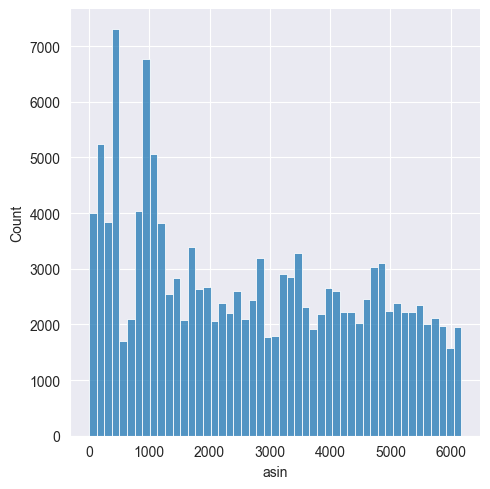

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.displot(df.asin)
plt.show()

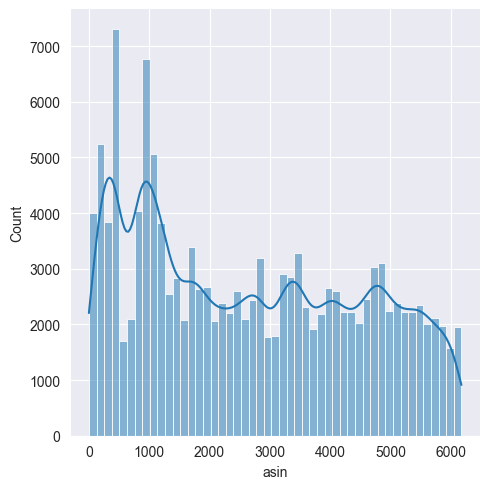

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

# plt.show()
# plt.savefig("Histogram_items.png")

hist_items_plot = sns.displot(df.asin,kde=True)
hist_items_plot.figure.savefig("Histogram_items.png") 

In [7]:
# barplot_reviews(df)

In [8]:
#timeline_reviews(df)

# Graficas


In [16]:
#============ Visualización ============#

def scatter_user_ratings_count(df, col_names, num_reviews):

   # count of ratings per reviewer
    data = df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
    data = data.query('cuenta>'+str(num_reviews))
    
    fig = px.scatter(data, x=col_names["col_id_reviewer"], y='cuenta', color='mean',
                    size='mean')

    fig.update_layout(
        title="Count of reviews for reviewers with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
        yaxis=dict(
            title='ratings count',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(
            title='reviewers',
            titlefont_size=16,
            tickfont_size=14,
        )
    )
    fig.write_image(execution_path/Path("3_DataPreparation/user_ratings_count_minR{}.png".format(num_reviews)))
    #return fig.show()

def scatter_user_ratings_mean(df, col_names, num_reviews):

   # mean of ratings per reviewer
    data = df.groupby([col_names["col_id_reviewer"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
    data = data.query('cuenta>'+str(num_reviews))

    fig = px.scatter(data, x=col_names["col_id_reviewer"], y='mean', color='cuenta',
                    size='cuenta')

    fig.update_layout(
        title="Mean of reviews for reviewers with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
        yaxis=dict(
            title='ratings mean',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(
            title='reviewers',
            titlefont_size=16,
            tickfont_size=14,
        )
    )
    
    fig.write_image(execution_path/Path("3_DataPreparation/user_ratings_mean_minR{}.png".format(num_reviews)))
    #return fig.show()

def scatter_product_ratings_mean(df, col_names, num_reviews):

    # mean of ratings per reviewer
    data = df.groupby([col_names["col_id_product"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
    data = data.query('cuenta>'+str(num_reviews))

    fig = px.scatter(data, x=col_names["col_id_product"], y='mean', color='cuenta',
                    size='cuenta')

    fig.update_layout(
        title="Mean of reviews for products with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0]) + " of " + str(df.shape[0]) + " ratings",
        yaxis=dict(
            title='ratings mean',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(
            title='products',
            titlefont_size=16,
            tickfont_size=14,
        )
    )
    fig.write_image(execution_path/Path("3_DataPreparation/product_ratings_mean_minR{}.png".format(num_reviews)))
    #return fig.show()  

def scatter_product_ratings_count(df, col_names, num_reviews):

    # count of ratings per reviewer
    data = df.groupby([col_names["col_id_product"]])[col_names["col_rating"]].agg(cuenta='count', mean='mean').sort_values(['cuenta', 'mean'], ascending=[False, False]).reset_index()
    data = data.query('cuenta>'+str(num_reviews))

    fig = px.scatter(data, x=col_names["col_id_product"], y='cuenta', color='mean',
                    size='mean')

    fig.update_layout(
        title="Count of reviews for products with more than "+ str(num_reviews) + " reviews. Showing "+ str(data.shape[0])  + " of " + str(df.shape[0]) + " ratings",
        yaxis=dict(
            title='ratings count',
            titlefont_size=16,
            tickfont_size=14,
        ),
        xaxis=dict(
            title='products',
            titlefont_size=16,
            tickfont_size=14,
        )
    )
    fig.write_image(execution_path/Path("3_DataPreparation/product_ratings_count_minR{}.png".format(num_reviews)))
    #return fig.show()  


In [22]:
print(min_reviews)
scatter_user_ratings_count(df, col_names, min_reviews)
scatter_user_ratings_mean(df, col_names,  min_reviews)
scatter_product_ratings_mean(df, col_names,  min_reviews)
scatter_product_ratings_count(df, col_names,  min_reviews)

3


# Procesado matriz por filas y columnas


La secuencia sería, eliminar el codigo que peta:

zero_positions = np.asarray(np.where(rating_mat.A==0)).T  #devuelve los indices traspuestos de cada posicion
print(rating_mat.A)
print(zero_positions)
print(dims[0])

y sustituir este código:

items2compute = []
for user in trange(dims[0]):
    aux = zero_positions[zero_positions[:, 0] == user][:, 1] #devuelve el item
    items2compute.append(aux[aux >= dims[0]])

por éste:

In [ ]:

   # generate test dataset
    items2compute = []
    items_zero_per_user = []
    for user in trange(dims[0]):
        aux1 = rating_mat[user, (dims[0]+1):]        
        items_zero_per_user = np.where(aux1.A==0)
        aux = items_zero_per_user[:] + (dims[0]+1)
        items2compute.append(aux[1])